In [78]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

# for using go ploting
import plotly.graph_objs as go
import plotly.offline as py

In [302]:
def ARIMA_StationaryTest(_label_col,_df,testType=1):
#     print("""
#     for dickeyFuller -> testType = 1
#     for kpss -> testType = 0
#     for acf -> testType = 2
#     for pacf -> testType = 3
#     for visual and MA ->testType = 4
#     """)
    
    if testType == 1:
        from statsmodels.tsa.stattools import adfuller
        addfull=adfuller(_df[_label_col], autolag='AIC')
        print("\n\n > Is the data stationary via addfuller test?")
        print("Test statistic = {:.3f}".format(addfull[0]))
        print("P-value = {:.3f}".format(addfull[1]))
        print("#Lag Used: = {:.3f}".format(addfull[2]))
        print("Critical values :")
        for k, v in addfull[4].items():
            print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<addfull[0] else "", 100-int(k[:-1])))

        def isStationary(tstats):
            if addfull[0] < 0.5:
                return 'TS data is stationary'
            else:
                return 'TS data is non-stationary'    
        print(isStationary(addfull[0]))
    if testType == 0:
        from statsmodels.tsa.stattools import kpss
        print("\n\n > Is the data stationary via kpss test?")
        kpss_result=kpss(_df[_label_col],regression='c')
        print("Test statistic = {:.3f}".format(kpss_result[0]))
        print("P-value = {:.3f}".format(kpss_result[1]))
        print("#Lag Used: = {:.3f}".format(kpss_result[2]))
        print("Critical values :")
        for k, v in kpss_result[3].items():
            print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<kpss_result[0] else "", 100.0-float(k[:-1])))


        def isStationary(tstats):
            if kpss_result[0] < 0.5:
                return 'TS data is stationary'
            else:
                return 'TS data is non-stationary'    
        print(isStationary(kpss_result[0]))
    if testType == 2:
        from statsmodels.graphics.tsaplots import plot_acf
        plt.figure(figsize=(20,6))
        ax= plt.subplot(111)
        plot_acf(_df[_label_col],ax=ax)
        plt.xticks(fontsize=20)
        plt.title("AutoCorrelation plot",fontsize=30,color='grey')
        plt.yticks(fontsize=20)
        plt.xlabel("#No of lags",fontsize=20)
        plt.ylabel("correlation value -1<>1",fontsize=20)
    if testType == 3:
        from statsmodels.graphics.tsaplots import plot_pacf
        plt.figure(figsize=(20,6))
        ax= plt.subplot(111)
        plot_pacf(_df[_label_col],ax=ax)
        plt.xticks(fontsize=20)
        plt.title("Partial AutoCorrelation plot",fontsize=30,color='grey')
        plt.yticks(fontsize=20)
        plt.xlabel("#No of lags",fontsize=20)
        plt.ylabel("correlation value -1<>1",fontsize=20)
        
    if testType == 4:
        print("\n\n1. use ploting to test stationarity in dataset(moving Average)")
        plt.rc('xtick', labelsize=25)     
        plt.rc('ytick', labelsize=25)
        plt.figure(figsize=(26,10))
        plt.rc('legend',fontsize=20) # using a size in points

        plt.suptitle("Rolling average(Original hourly data) to test stationarity in data", y=1.0, fontsize=30)

        # 1. Original TS Junction 1
        plt.plot(_df[_label_col],label='Orig Train Count',color='grey')

        # 2. Original TS Junction 1 Rolling mean and std
        plt.plot(_df[_label_col].rolling(window=24).mean(),label='Orig Rolling mean',color='brown' )
        plt.plot(_df[_label_col].rolling(window=24).std(),label='Orig Rolling std',color='blue' )
        plt.legend(loc='best')

def ARIMAcorrPlot(_label_col,_df):
    from statsmodels.tsa.stattools import acf, pacf 
    lag_acf = acf(_df.dropna()[_label_col], nlags=30) 
    lag_pacf = pacf(_df.dropna()[_label_col], nlags=30, method='ols')
    lag_acf,lag_pacf

    # Lets plot Autocorrelation Function
    figure = plt.figure(figsize=(25,7))
    plt.rc('xtick', labelsize=25)     
    plt.rc('ytick', labelsize=25)
    plt.rc('legend',fontsize=20) # using a size in points
    plt.plot(lag_acf) 
    plt.axhline(y=0,linestyle='--',color='gray') 
    plt.axhline(y=-1.96/np.sqrt(len(_df.dropna())),linestyle='--',color='Red',label='Lower Confidence Interval') 
    plt.axhline(y=1.96/np.sqrt(len(_df.dropna())),linestyle='--',color='Blue',label='Upper Confidence Interval') 
    plt.title('Autocorrelation Function (Give Q value on first cut point Upper CI)',fontsize=35) 
    plt.legend(loc='best')


    # Lets plot Partial Autocorrelation Function
    figure = plt.figure(figsize=(25,7))
    plt.rc('xtick', labelsize=25)     
    plt.rc('ytick', labelsize=25)
    plt.rc('legend',fontsize=20) # using a size in points
    plt.plot(lag_pacf) 
    plt.axhline(y=0,linestyle='--',color='gray') 
    plt.axhline(y=-1.96/np.sqrt(len(_df.dropna())),linestyle='--',color='red',label='Lower Confidence Interval') 
    plt.axhline(y=1.96/np.sqrt(len(_df.dropna())),linestyle='--',color='blue',label='Upper Confidence Interval') 
    plt.title('Partial Autocorrelation Function (Give P value on first cut point Upper CI)',fontsize=35) 
    plt.legend(loc='best')

def decompositionTimeSeries(_label_col,_df,model_type=1,_freq=5):
    print("""
          for additive, pass model_type=1 or
          for multiplicative, pass model_type=2
          """)
    import statsmodels.api as sm
    if model_type == 1:
        _model_type='additive'
        decomposition = sm.tsa.seasonal_decompose(_df[_label_col],model=_model_type,freq=_freq)
    else:
        _model_type='multiplicative'
        decomposition = sm.tsa.seasonal_decompose(_df[_label_col],model=_model_type,freq=_freq)
        
        
    
    # multiplicative
    #decomposition = sm.tsa.seasonal_decompose(_df[_label_col],model=_model_type)
    #decomposition = sm.tsa.seasonal_decompose(J1_log_train[label_col],model="multiplicative")
    trend = pd.DataFrame(decomposition.trend.values,columns=[_label_col])
    seasonal = pd.DataFrame(decomposition.seasonal.values ,columns=[_label_col])
    residual = pd.DataFrame(decomposition.resid.values ,columns=[_label_col])

    trend.dropna(inplace=True)
    seasonal.dropna(inplace=True)
    residual.dropna(inplace=True)
    plt.figure(figsize=(26,5))
    fig,axs = plt.subplots(4,1)
    _df[_label_col].plot(figsize=(26,15),ax=axs[0],color='orange',title='observed',fontsize=20)
    trend[_label_col].fillna(0).plot(figsize=(26,15),ax=axs[1],color='red',title='trend',fontsize=20)
    seasonal[_label_col].plot(ax=axs[2],color='blue',title='seasonal',fontsize=20)
    residual[_label_col].plot(ax=axs[3],color='black',title='residual',fontsize=20)

## Observe the test result of KPSS and dickeyFuller test
KPSS and dickeyFuller are two differents tests what use to check the stationarity of the TS

    Case 1: Both tests conclude that the
           -> series is not stationary
    Case 2: Both tests conclude that the
           -> series is stationary
    Case 3: KPSS = stationary & ADF = not stationary
          -> trend stationary, remove the trend to make series strict stationary
    Case 4: KPSS = not stationary & ADF = stationary
           -> difference stationary, use differencing to make series stationary

In [304]:
# Data points are often non-stationary that have means, variances, and covariances 
# that change over time. 

# Non-stationary behaviors can be trends, cycles, random walks, or combinations of the three.


In [10]:
path ="/Users/keeratjohar2305/Downloads/"
import getPreProcessingFunction as PPM
import UniVEDA_catFunction as catF
import UniVEDA_conti_methods as contiF
import BiVEDA_Function as bif

In [31]:
train=pd.read_csv(path + "train_0irEZ2H.csv")
test=pd.read_csv(path + "test_nfaJ3J5.csv")
sub=pd.read_csv(path + "sample_submission_pzljTaX.csv")
label_col='units_sold'

In [64]:
train.shape,test.shape,sub.shape
train['total_price'].fillna(train['total_price'].median(),inplace=True)

In [65]:
pd.DataFrame({'trainnull': train.isna().sum() ,'testnull':test.isna().sum(),'type':train.dtypes})

,trainnull,testnull,type
base_price,0,0.0,float64
is_display_sku,0,0.0,int64
is_featured_sku,0,0.0,int64
record_ID,0,0.0,int64
sku_id,0,0.0,int64
store_id,0,0.0,int64
total_price,0,0.0,float64
units_sold,0,NaN,int64
week,0,0.0,object


#### Example of Seasonality and treading
1. Here, there is a clear and increasing trend. 
2. There is also a strong seasonal pattern that increases in size as the level of the series increases. 
3. The sudden drop at the start of each year
4. Any forecasts of this series would need to capture the seasonal pattern, and the fact that the trend is changing slowly.
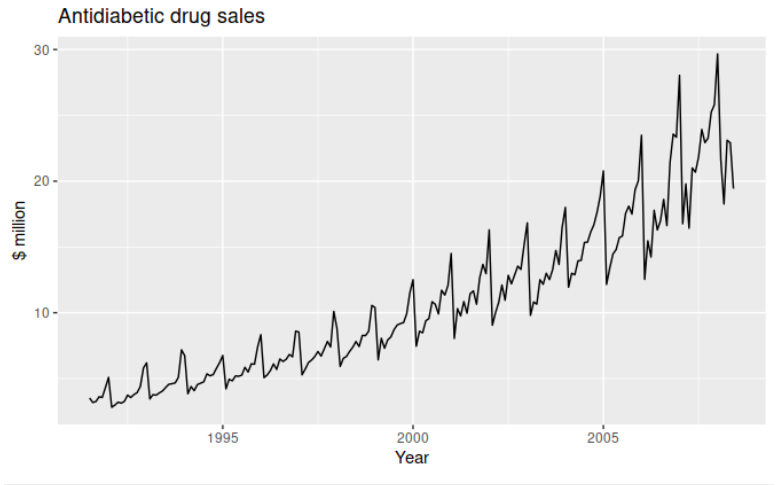

##### Dont get confuse between Seasonality and cyclic variation
1. Cyclic variation 
    A cycle occurs when the data exhibit rises and falls that are not of a fixed frequency. These fluctuations are usually due to economic conditions, and are often related to the “business cycle”. The duration of these fluctuations is usually at least 2 years.

    ###### Many people confuse cyclic behaviour with seasonal behaviour, 
    but they are really quite different. If the fluctuations are not of a fixed frequency then they are cyclic; if the frequency is unchanging and associated with some aspect of the calendar, then the pattern is seasonal. In general, the average length of cycles is longer than the length of a seasonal pattern, and the magnitudes of cycles tend to be more variable than the magnitudes of seasonal patterns.
    
## What to learn in TS data
Many time series include all of these ( trend, cycles and seasonality ) and in case nothing is present in time sereis data, challenge is to identify them, please look at next slide


### Four examples of time series showing different patterns.
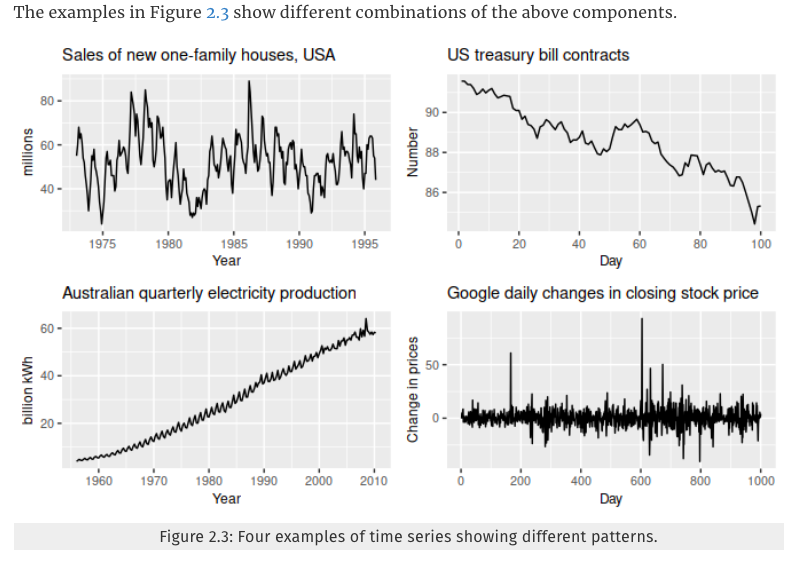

1. The monthly housing sales (top left) show strong seasonality within each year, as well as some strong cyclic behaviour with a period of about 6–10 years. There is no apparent trend in the data over this period.

2. The US treasury bill contracts (top right) show results from the Chicago market for 100 consecutive trading days in 1981. Here there is no seasonality, but an obvious downward trend. Possibly, if we had a much longer series, we would see that this downward trend is actually part of a long cycle, but when viewed over only 100 days it appears to be a trend.

3. The Australian quarterly electricity production (bottom left) shows a strong increasing trend, with strong seasonality. There is no evidence of any cyclic behaviour here.

4. The daily change in the Google closing stock price (bottom right) has no trend, seasonality or cyclic behaviour. There are random fluctuations which do not appear to be very predictable, and no strong patterns that would help with developing a forecasting model.


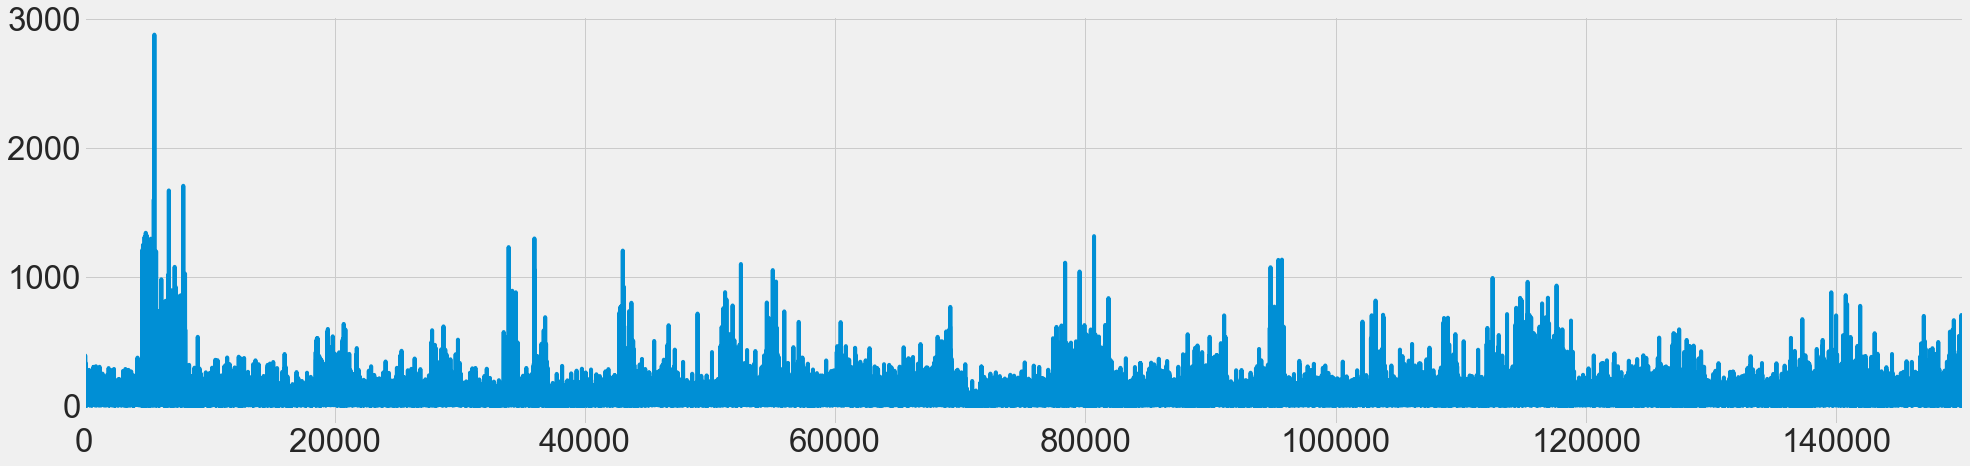

In [288]:
train[label_col].plot(figsize=(30,7))
# No tread

In [66]:
PPM.desc1(train)

,dtypes,null_count,total count,unique_count,missing value ratio,variance of numerics,std,mean,min,max,skew,kurt
is_featured_sku,int64,0.0,150150.0,2.0,0.0,9.000000e-02,0.29,0.10,0.000,1.00,2.750,5.565
is_display_sku,int64,0.0,150150.0,2.0,0.0,1.200000e-01,0.34,0.13,0.000,1.00,2.159,2.661
sku_id,int64,0.0,150150.0,28.0,0.0,7.318340e+09,85547.30,254761.00,216233.000,679023.00,3.049,9.271
store_id,int64,0.0,150150.0,76.0,0.0,3.789530e+05,615.59,9199.42,8023.000,9984.00,-0.636,-0.928
week,object,0.0,150150.0,130.0,0.0,0.000000e+00,0.00,0.00,0.000,0.00,0.000,0.000
base_price,float64,0.0,150150.0,572.0,0.0,1.231250e+04,110.96,219.43,61.275,562.16,1.209,0.868
total_price,float64,0.0,150150.0,646.0,0.0,1.067260e+04,103.31,206.63,41.325,562.16,1.251,1.238
units_sold,int64,0.0,150150.0,708.0,0.0,3.624990e+03,60.21,51.67,1.000,2876.00,6.115,93.686
record_ID,int64,0.0,150150.0,150150.0,0.0,3.768250e+09,61386.00,106272.00,1.000,212644.00,0.001,-1.200


In [67]:
# Observation 1
# multiple distinct sku_id, store_id,week , result number is greater than train.shape
# That means train data has missing value for some of the commbination of sku_id and store_id
28.0*76.0*130.0,train.shape

(276640.0, (150150, 9))

This pivoted dataframe has average sales per each store per each item.  
Let use this dataframe and produce some interesting visualizations!


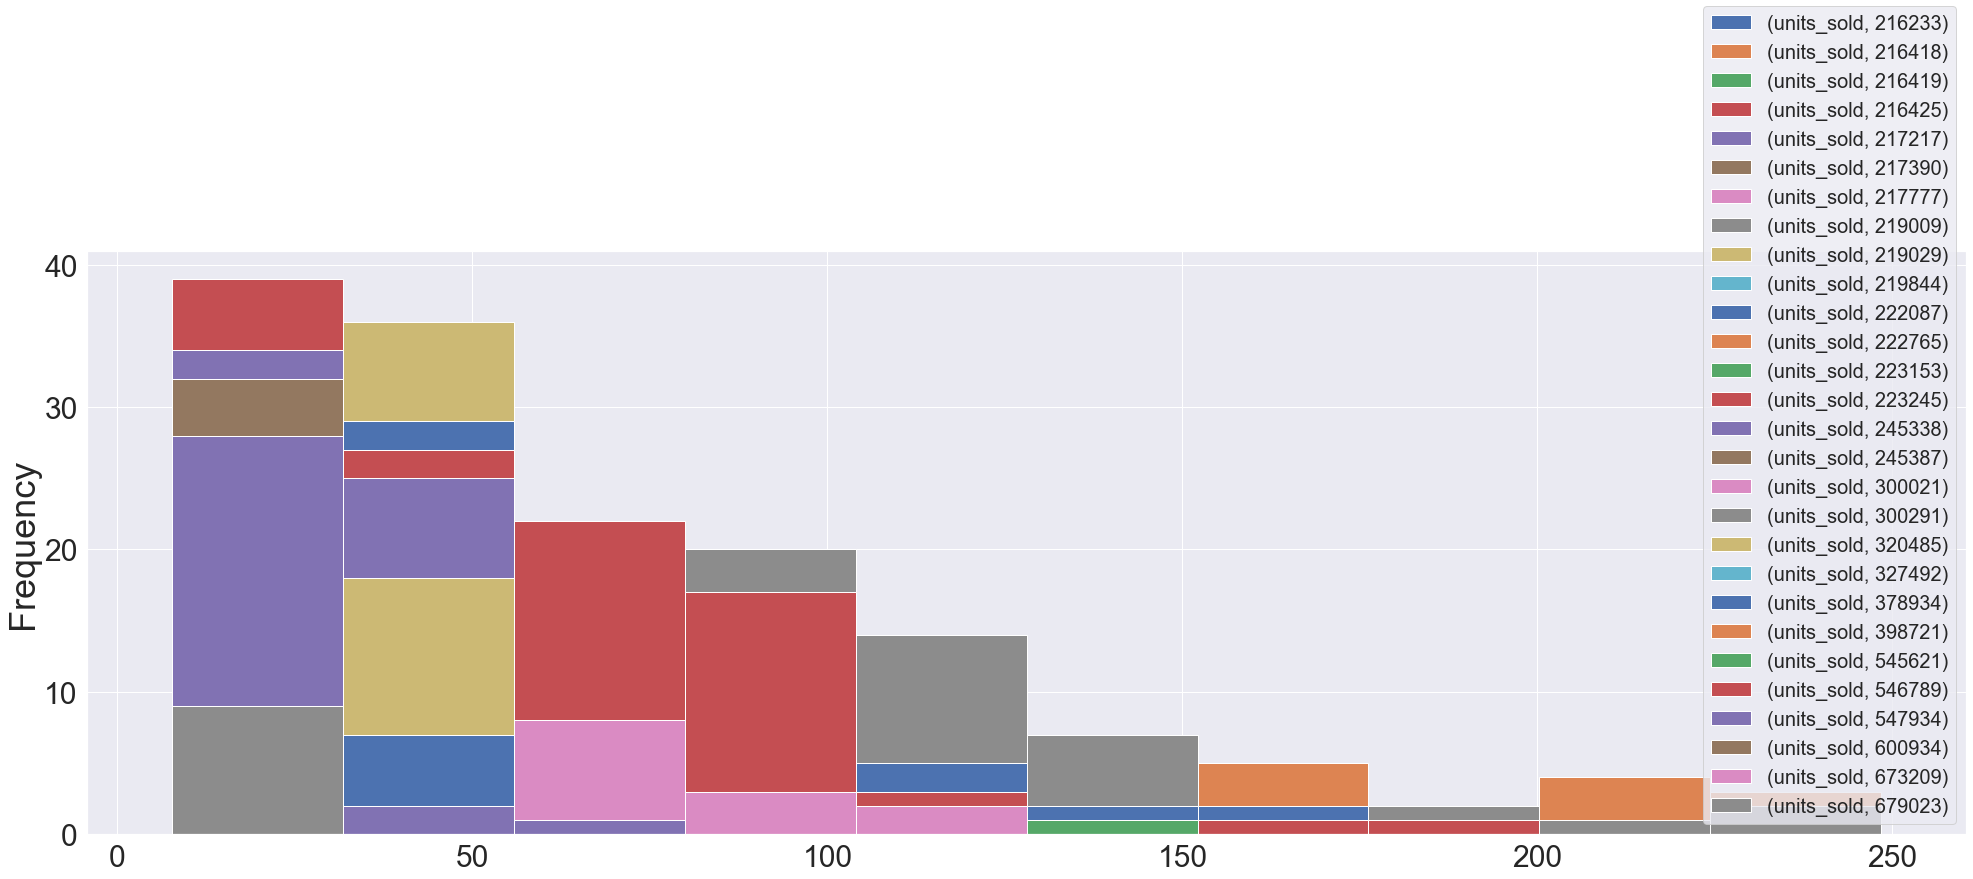

In [70]:
train_sale_pivot=pd.pivot_table(train, index = 'store_id', columns='sku_id',values=[label_col])
train_sale_pivot.plot(kind="hist",figsize=(30,10),fontsize=30)
plt.legend(fontsize=20)
print("""This pivoted dataframe has average sales per each store per each item.  
Let use this dataframe and produce some interesting visualizations!""")

In [71]:
display(train_sale_pivot)


units_sold                                                \
sku_id        216233      216418      216419     216425     217217   
store_id                                                             
8023      121.607692  248.376923  222.830769  85.015385        NaN   
8058       44.761538   98.453846   85.238462  39.369231        NaN   
8063       32.246154   47.246154   39.584615        NaN  16.692308   
8091       29.107692   26.376923   28.307692  25.669231        NaN   
8094       55.946154   88.230769   96.769231  26.746154  26.223077   
8095       92.723077  167.007692   97.830769  77.200000        NaN   
8121       35.623077   50.246154         NaN  19.323077  21.776923   
8218       26.323077   45.707692   37.215385  10.546154  14.107692   
8222       95.253846  174.107692  104.669231  80.807692        NaN   
8317       59.861538         NaN   54.307692  20.523077  13.192308   
8319       37.584615         NaN         NaN  15.407692        NaN   
8392       32.115385         NaN         NaN  16.323077        NaN   
8398       59.023077  104.569231   71.576923  45.969231        NaN   
8400       38.576923   58.646154   59.992308  37.715385        NaN   
8422       27.138462   41.869231   37.369231        NaN        NaN   
8438       51.246154   84.938462   81.176923  25.892308  20.884615   
8555       26.246154   27.330769   25.984615        NaN        NaN   
8562       46.746154  148.192308  102.853846  46.315385        NaN   
8869       68.061538  124.692308   94.984615  61.138462  31.569231   
8911       27.684615   49.684615   34.846154  14.853846  27.338462   
8991       41.707692   86.807692   87.161538  23.553846  20.584615   
9001             NaN         NaN    8.423077        NaN        NaN   
9043       36.969231   85.038462   53.769231  31.092308        NaN   
9092       25.484615   66.607692   45.807692  11.353846        NaN   
9112       83.353846  205.284615  178.200000  63.292308        NaN   
9132       31.707692         NaN   15.023077  12.815385  17.169231   
9147       51.923077   97.469231   81.492308  55.376923        NaN   
9164       44.584615  121.523077   98.023077  36.976923        NaN   
9178       16.738462         NaN         NaN        NaN        NaN   
9190       74.692308         NaN   51.161538  28.453846  19.153846   
...              ...         ...         ...        ...        ...   
9490       32.553846   56.361538   50.715385  14.038462        NaN   
9498       57.507692   29.307692   26.469231  29.253846        NaN   
9532       54.446154   58.546154   64.569231  26.707692  34.253846   
9578       33.192308   60.153846   58.023077  23.592308        NaN   
9611       63.015385  203.992308  138.300000  57.823077        NaN   
9613       77.853846  241.800000  197.461538  72.961538        NaN   
9632       38.376923   28.738462   24.876923  15.361538        NaN   
9672       49.161538   90.123077   70.938462  40.969231        NaN   
9680       21.500000   38.153846   40.476923  13.530769        NaN   
9700       12.053846   10.376923         NaN        NaN        NaN   
9713       40.738462  129.046154  105.761538  37.376923        NaN   
9731       38.576923   73.823077   40.361538  35.792308        NaN   
9745       54.692308  154.038462  103.169231  38.069231        NaN   
9770       30.792308   32.553846         NaN        NaN        NaN   
9789       16.600000   43.100000   46.553846        NaN        NaN   
9809       44.330769   94.461538   85.423077  36.884615        NaN   
9813       46.253846   26.838462   23.253846  20.415385  24.907692   
9823      105.415385  160.807692  103.238462  69.484615        NaN   
9837       45.930769   62.307692   49.538462  41.592308  40.230769   
9845      105.353846  220.307692  169.961538  91.292308  26.953846   
9872       36.330769   92.300000   77.992308  20.792308  20.761538   
9876       33.069231   28.130769         NaN        NaN  15.246154   
9879       35.200000   45.746154   59.823077  19.900000        NaN   
9880       49.392308

# Store Wise Sale

In [73]:
train_sale_pivot['avg_sale'] = train_sale_pivot.apply(lambda r: r.mean(), axis=1)

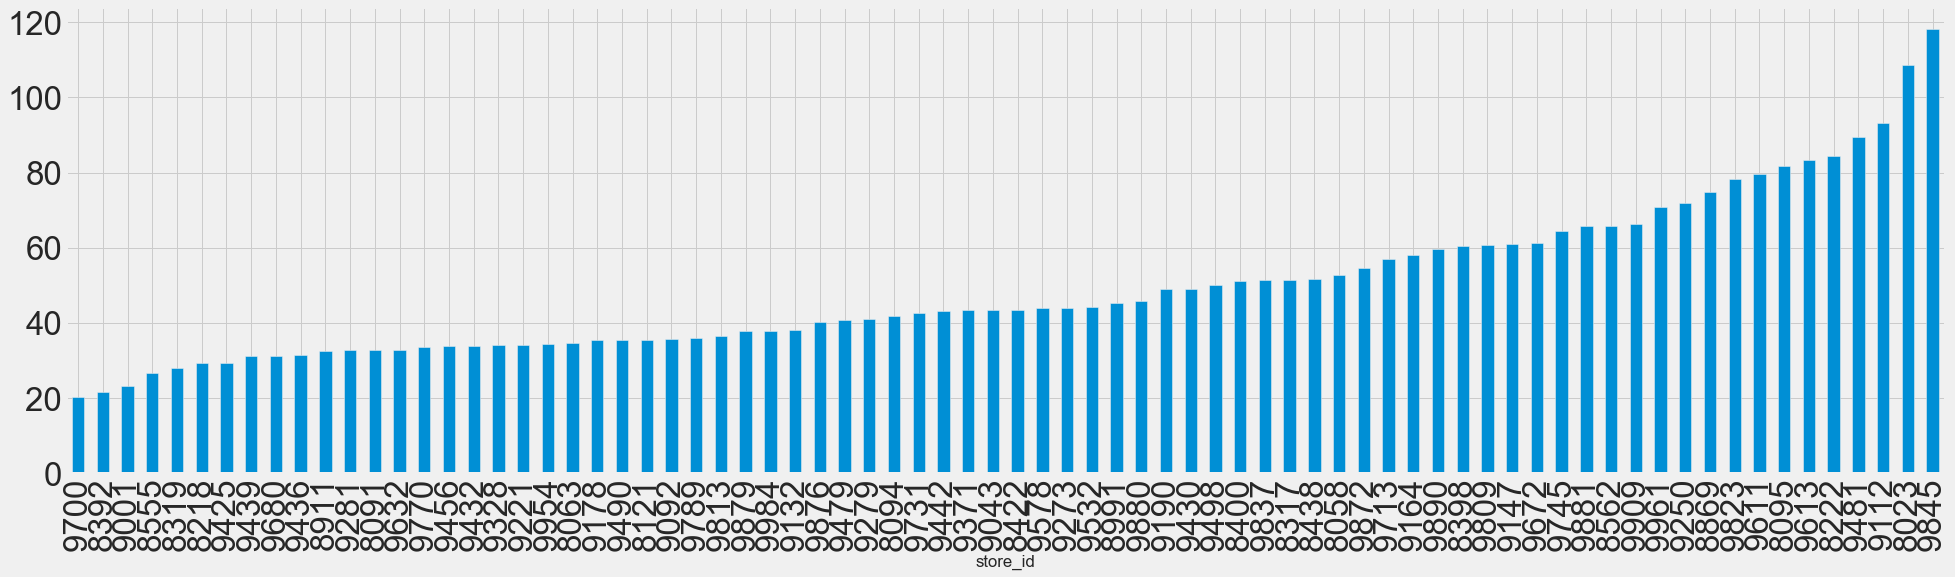

In [80]:
# Scatter plot of average sales per store
sales_store_data = go.Scatter(
    y = train_sale_pivot.avg_sale.values,
    mode='markers',
    marker=dict(
        size = train_sale_pivot.avg_sale.values,
        color = train_sale_pivot.avg_sale.values,
        colorscale='Viridis',
        showscale=True
    ),
    text = train_sale_pivot.index.values
)
data = [sales_store_data]

sales_store_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per store',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Stores',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_store_layout)
py.iplot(fig,filename='scatter_sales_store')


# mean units sold value is increasing store_wise wise
plt.figure(figsize=(30,8))
train.groupby('store_id')[label_col].mean().sort_values().plot.bar()
# top threr selling store_id - 9845,8023,9112

# SKU_ID WISE SALE

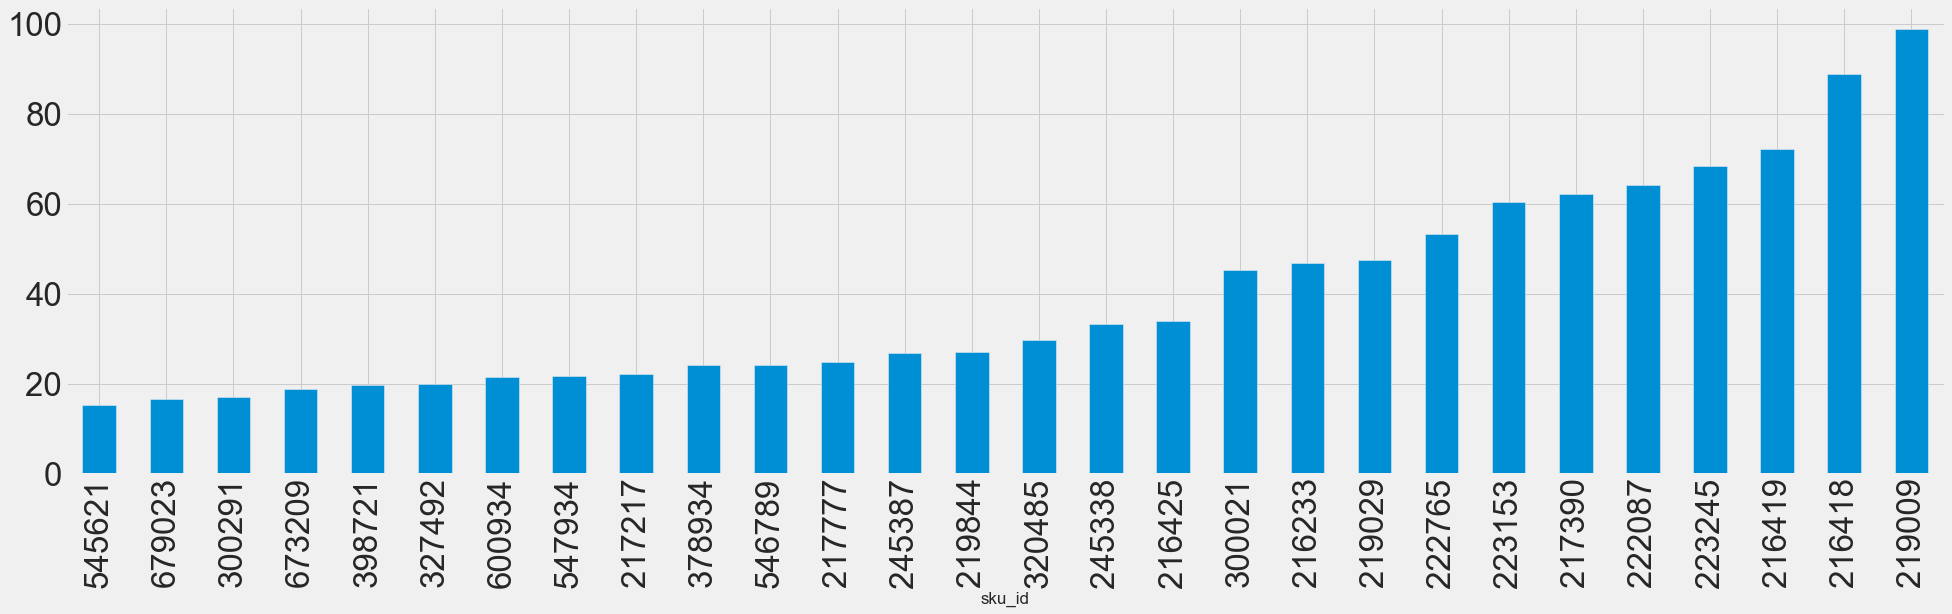

In [96]:
# Scatter plot of average sales per store
#train_sale_pivot['avg_sale'] = 
sku_idWiseSale=train_sale_pivot.apply(lambda r: r.mean(), axis=0)


sales_store_data = go.Scatter(
    y = sku_idWiseSale.values,
    mode='markers',
    marker=dict(
        size = sku_idWiseSale.values,
        color = sku_idWiseSale.values,
        colorscale='Viridis',
        showscale=True
    ),
    text = sku_idWiseSale.index.levels[1].values
)
data = [sales_store_data]

sales_store_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per store',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Stores',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_store_layout)
py.iplot(fig,filename='scatter_sales_store')



# mean units sold value is increasing sku_id wise
plt.figure(figsize=(30,8))
train.groupby('sku_id')[label_col].mean().sort_values().plot.bar()

# top threr selling skuid - 219009,216418,216419

In [103]:
sku_idWiseSale=train_sale_pivot.apply(lambda r: r.mean(), axis=0).sort_values()
#avg_sales_per_item_across_stores_df.avg_sale.values
# Scatter plot of average sales per item
sales_item_data = go.Bar(
    x=[i for i in range(0, 50)],
    y=sku_idWiseSale.values,
    marker=dict(
        color=sku_idWiseSale.values,
        colorscale='Blackbody',
        showscale=True
    ),
    text = sku_idWiseSale.index.levels[1].values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 55,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_item_layout)
py.iplot(fig,filename='scatter_sales_item')

 Lets create Vertical Multi HISTOGRAM plot for column 
['total_price']


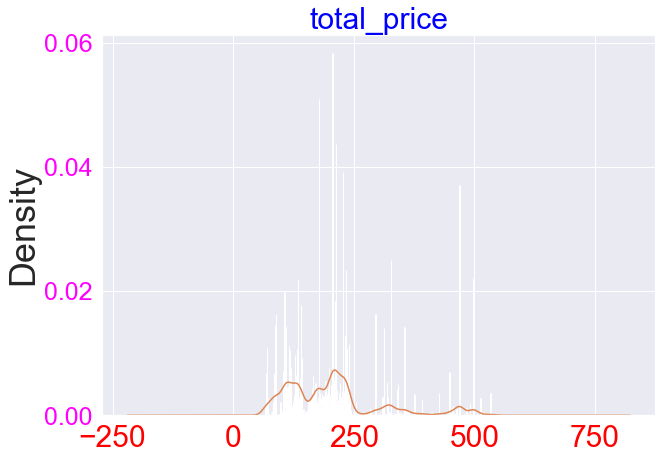

 Lets create Vertical Multi HISTOGRAM plot for column 
['total_price']


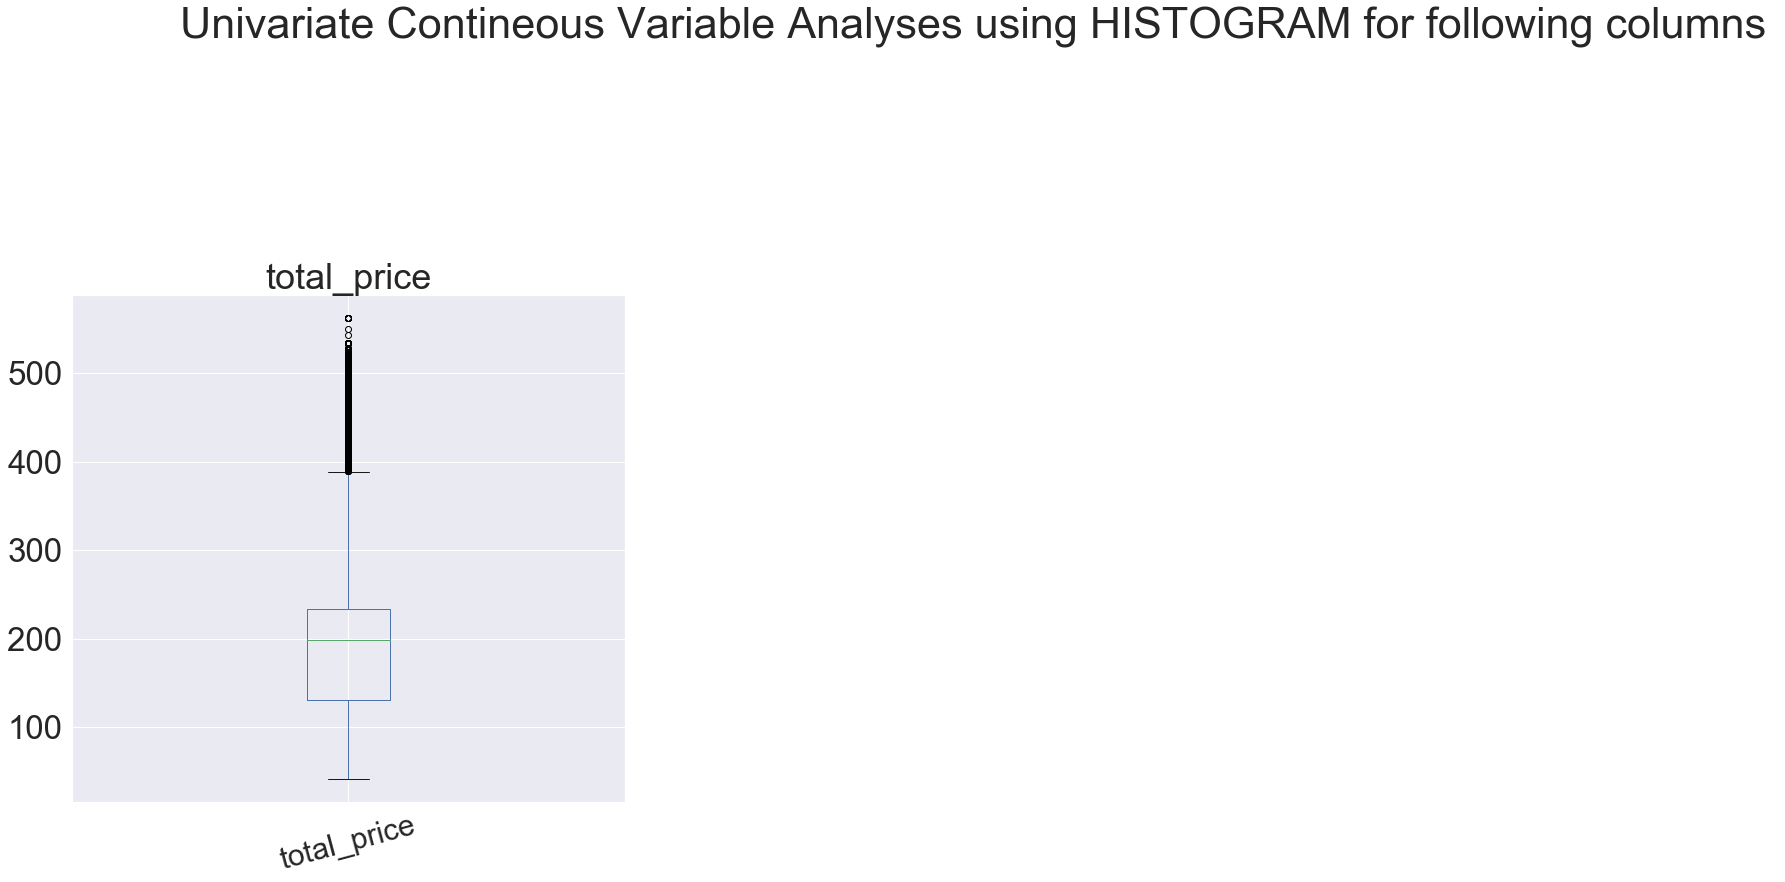

In [21]:
contiF.UniVEDA_conti_cols_HIST(['total_price'],train)
contiF.UniVEDA_conti_cols_BOX(['total_price'],train)

In [97]:
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


In [108]:
train['sku_id'].head(4).values

array([216418, 216419, 216425, 216233])

## Let us see how sales of a given item in a given store varies in a span of 5 years.
#### lets try to understand , seasonality, noise, treading in the data

In [107]:
def Time_visualization(data):
    store_item_df = data.copy()
    # First, let us filterout the required data
    store_id = 8091   # Some store
    sku_id = 216418    # Some item
    print('Before filter:', store_item_df.shape)
    store_item_df = store_item_df[store_item_df.store_id == store_id]
    store_item_df = store_item_df[store_item_df.sku_id == sku_id]
    print('After filter:', store_item_df.shape)
    #display(store_item_df.head())

    # Let us plot this now
    store_item_ts_data = [go.Scatter(
        x=store_item_df.week,
        y=store_item_df[label_col])]
    py.iplot(store_item_ts_data)
    return store_item_df

store_item_df = Time_visualization(train)

Before filter: (150150, 9)
After filter: (130, 9)


In [110]:
def sales_monthly(data):
    multi_store_item_df = data.copy()
    # First, let us filterout the required data
    store_ids = [8091, 8091, 8091, 8091]   # Some stores
    sku_ids = [216418, 216419, 216425, 216233]    # Some items
    print('Before filter:', multi_store_item_df.shape)
    multi_store_item_df = multi_store_item_df[multi_store_item_df.store_id.isin(store_ids)]
    multi_store_item_df = multi_store_item_df[multi_store_item_df.sku_id.isin(sku_ids)]
    print('After filter:', multi_store_item_df.shape)
    #display(multi_store_item_df)
    # TODO Monthly avg sales

    # Let us plot this now
    multi_store_item_ts_data = []
    for st,it in zip(store_ids, sku_ids):
        flt = multi_store_item_df[multi_store_item_df.store_id == st]
        flt = flt[flt.sku_id == it]
        multi_store_item_ts_data.append(go.Scatter(x=flt.week, y=flt[label_col], name = "Store:" + str(st) + ",Item:" + str(it)))
    py.iplot(multi_store_item_ts_data)
    return (multi_store_item_df)

multi_store_item_df = sales_monthly(train)

Before filter: (150150, 9)
After filter: (520, 9)


Observe the test result of KPSS and dickeyFuller test
KPSS and dickeyFuller are two differents tests what use to check the stationarity of the TS

    Case 1: Both tests conclude that the
           -> series is not stationary
    Case 2: Both tests conclude that the
           -> series is stationary
    Case 3: KPSS = stationary & ADF = not stationary
          -> trend stationary, remove the trend to make series strict stationary
    Case 4: KPSS = not stationary & ADF = stationary
           -> difference stationary, use differencing to remove seasonality and make data series stationary



 > Is the data stationary via addfuller test?
Test statistic = -32.653
P-value = 0.000
#Lag Used: = 75.000
Critical values :
	1%: -3.430393574582239 - The data is  stationary with 99% confidence
	5%: -2.8615592593534824 - The data is  stationary with 95% confidence
	10%: -2.5667802510675894 - The data is  stationary with 90% confidence
TS data is stationary


In [301]:
ARIMA_StationaryTest(label_col,df,testType=0)



 > Is the data stationary via kpss test?
Test statistic = 0.707
P-value = 0.013
#Lag Used: = 75.000
Critical values :
	10%: 0.347 - The data is not stationary with 90.0% confidence
	5%: 0.463 - The data is not stationary with 95.0% confidence
	2.5%: 0.574 - The data is not stationary with 97.5% confidence
	1%: 0.739 - The data is  stationary with 99.0% confidence
TS data is non-stationary


In [305]:
# Our data has seasonality

In [152]:
#df.Month = 
week_of_year_formated=pd.to_datetime(train['week'])#.week_of_year


In [290]:
df=train.copy()
df['date'] = week_of_year_formated
df.index = week_of_year_formated


In [291]:
df['quarter'] = df['date'].dt.quarter
df['year'] = df['date'].dt.year
df['month_of_year'] = df['date'].dt.month
df['week_of_year'] = df['date'].dt.weekofyear

year = df.groupby('year')['units_sold'].sum()
quarter= df.groupby('quarter')['units_sold'].sum()
month_of_year = df.groupby('month_of_year')['units_sold'].sum()
week_of_year = df.groupby('week_of_year')['units_sold'].sum()


In [292]:
Yquarter= df.groupby(['year','quarter'])['units_sold'].sum()
Ymonth_of_year = df.groupby(['year','month_of_year'])['units_sold'].sum()
Yweek_of_year = df.groupby(['year','week_of_year'])['units_sold'].sum()

Text(0.5, 0, 'week_of_year')

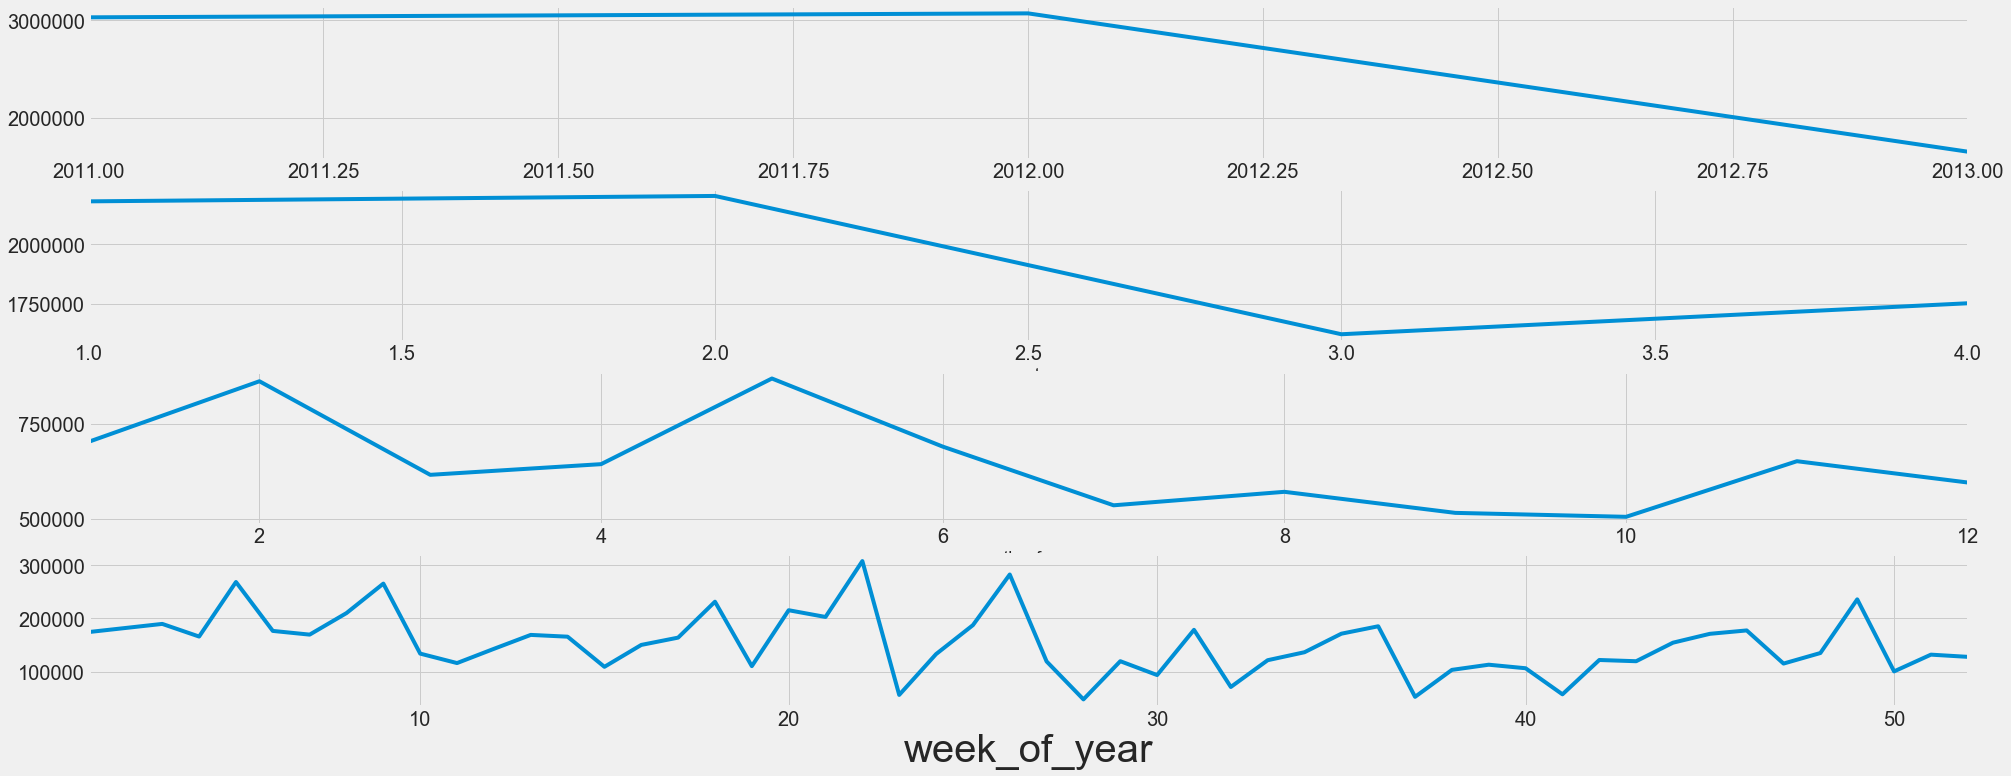

In [293]:
fig, axs = plt.subplots(4,1) 
year.plot(figsize=(30,12),ax=axs[0],fontsize=20)
plt.xlabel("year",fontsize=40)
quarter.plot(figsize=(30,12),ax=axs[1],fontsize=20)
plt.xlabel("quarter",fontsize=40)
month_of_year.plot(figsize=(30,12),ax=axs[2],fontsize=20)
plt.xlabel("month_of_year",fontsize=40)
week_of_year.plot(figsize=(30,12),ax=axs[3],fontsize=20)
plt.xlabel("week_of_year",fontsize=40)


Text(0.5, 0, 'week_of_year')

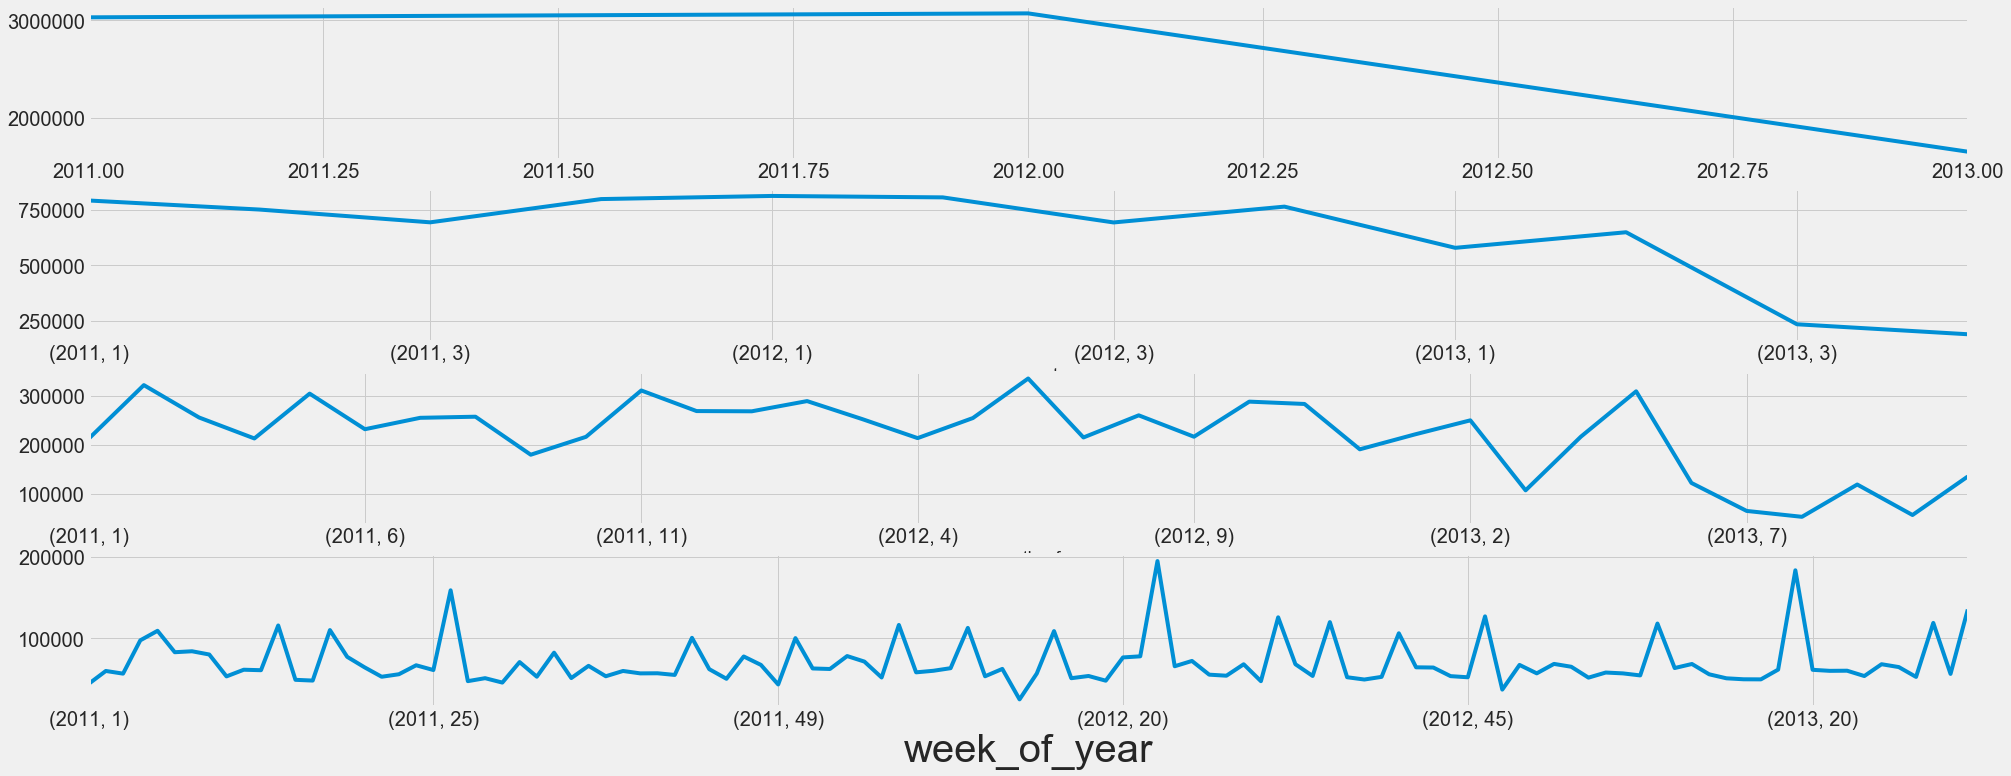

In [294]:
fig, axs = plt.subplots(4,1) 
year.plot(figsize=(30,12),ax=axs[0],fontsize=20)
plt.xlabel("year",fontsize=40)
Yquarter.plot(figsize=(30,12),ax=axs[1],fontsize=20)
plt.xlabel("quarter",fontsize=40)
Ymonth_of_year.plot(figsize=(30,12),ax=axs[2],fontsize=20)
plt.xlabel("month_of_year",fontsize=40)
Yweek_of_year.plot(figsize=(30,12),ax=axs[3],fontsize=20)
plt.xlabel("week_of_year",fontsize=40)


In [400]:
y=week_of_year.reset_index()

In [403]:
ARIMA_StationaryTest(label_col,y,testType=1)



 > Is the data stationary via addfuller test?
Test statistic = -2.215
P-value = 0.201
#Lag Used: = 3.000
Critical values :
	1%: -3.5778480370438146 - The data is not stationary with 99% confidence
	5%: -2.925338105429433 - The data is not stationary with 95% confidence
	10%: -2.6007735310095064 - The data is not stationary with 90% confidence
TS data is stationary


In [404]:
ARIMA_StationaryTest(label_col,y,testType=0)



 > Is the data stationary via kpss test?
Test statistic = 0.387
P-value = 0.083
#Lag Used: = 11.000
Critical values :
	10%: 0.347 - The data is not stationary with 90.0% confidence
	5%: 0.463 - The data is  stationary with 95.0% confidence
	2.5%: 0.574 - The data is  stationary with 97.5% confidence
	1%: 0.739 - The data is  stationary with 99.0% confidence
TS data is stationary


In [416]:
# import statsmodels.api as sm
# def bestArimaParams(_df,season4thparam=12):
#     import itertools 
#     import statsmodels.api as sm
#     p = d = q = range(0, 2)
#     pdq = list(itertools.product(p, d, q))
#     seasonal_pdq = [(x[0], x[1], x[2], season4thparam) for x in pdq]

#     print('Examples of parameter combinations for Seasonal ARIMA...')
#     print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
#     print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
#     print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
#     print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
#     Arima_Score_df=pd.DataFrame(columns=['pdq','seasonal_pdq','aic_score'])
#     for param in pdq:
#         for param_seasonal in seasonal_pdq:
#             try:
#                 mod = sm.tsa.statespace.SARIMAX(_df,
#                                                 order=param,
#                                                 seasonal_order=param_seasonal,
#                                                 enforce_stationarity=False,
#                                                 enforce_invertibility=False)
#                 results = mod.fit()
#                 Arima_Score_df = Arima_Score_df.append({'pdq':param,'seasonal_pdq':param_seasonal,'aic_score':results.aic},ignore_index=True)
#             except:
#                  continue
#     return Arima_Score_df.sort_values('aic_score').head(5)
# bestArimaParams(y,26)

In [430]:
import statsmodels.api as sm
def bestArimaParams(_df,season4thparam=12,useTrycatch=1):
    import itertools 
    import statsmodels.api as sm
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], season4thparam) for x in pdq]

    print('Examples of parameter combinations for Seasonal ARIMA...')
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
    print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
    print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
    Arima_Score_df=pd.DataFrame(columns=['pdq','seasonal_pdq','aic_score'])                
    def DontUsetryCatch():
        mod = sm.tsa.statespace.SARIMAX(_df,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        Arima_Score_df = Arima_Score_df.append({'pdq':param,'seasonal_pdq':param_seasonal,'aic_score':results.aic},ignore_index=True)

                    
                    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            if useTrycatch == 1:
                try:
                    mod = sm.tsa.statespace.SARIMAX(_df,
                                                    order=param,
                                                    seasonal_order=param_seasonal,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                    results = mod.fit()
                    Arima_Score_df = Arima_Score_df.append({'pdq':param,'seasonal_pdq':param_seasonal,'aic_score':results.aic},ignore_index=True)
                except:
                    continue
                
            elif useTrycatch == 0:
                DontUsetryCatch
                
    return Arima_Score_df.sort_values('aic_score').head(5)

In [431]:
bestArimaParams(week_of_year,12,useTrycatch=1)

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


,pdq,seasonal_pdq,aic_score
31,"(0, 1, 1)","(1, 1, 1, 12)",613.682255
63,"(1, 1, 1)","(1, 1, 1, 12)",615.603534
23,"(0, 1, 0)","(1, 1, 1, 12)",632.650069
15,"(0, 0, 1)","(1, 1, 1, 12)",634.398135
47,"(1, 0, 1)","(1, 1, 1, 12)",635.613261


In [500]:
def FindNo_ofObservationReq(p,d,q,P,D,Q,s):
    print(d + D*s + max(3*q + 1, 3*Q*s + 1, p, P*s) + 1,"Observation Required")
FindNo_ofObservationReq(0,1,1,1,1,1,12)
mod = sm.tsa.statespace.SARIMAX(week_of_year,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

51 Observation Required
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4970      0.454     -1.095      0.273      -1.387       0.393
ar.S.L12      -0.3284      0.672     -0.489      0.625      -1.645       0.988
ma.S.L12      -0.7612      0.502     -1.518      0.129      -1.744       0.222
sigma2      9.868e+09   3.28e-11   3.01e+20      0.000    9.87e+09    9.87e+09


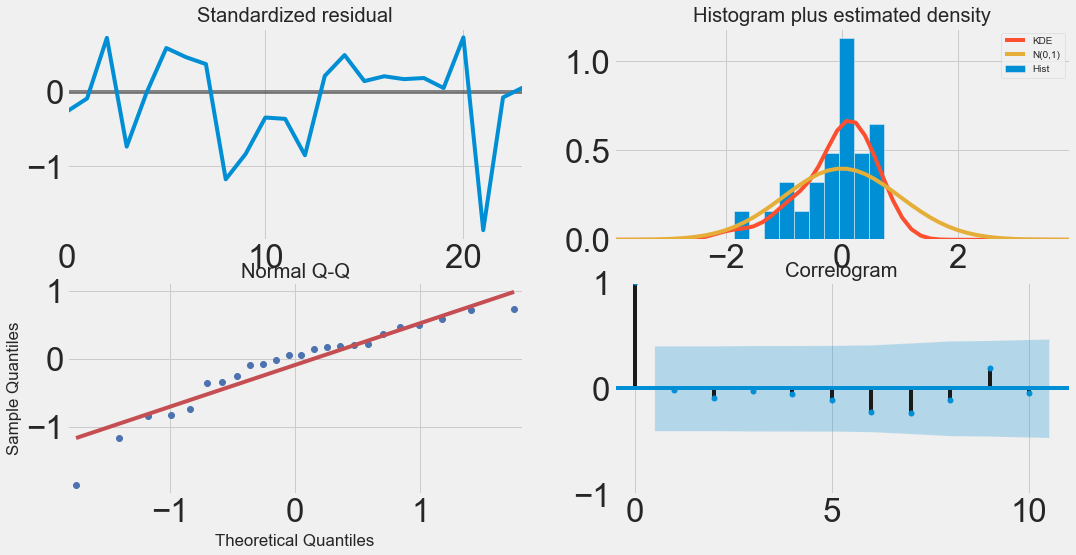

In [501]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

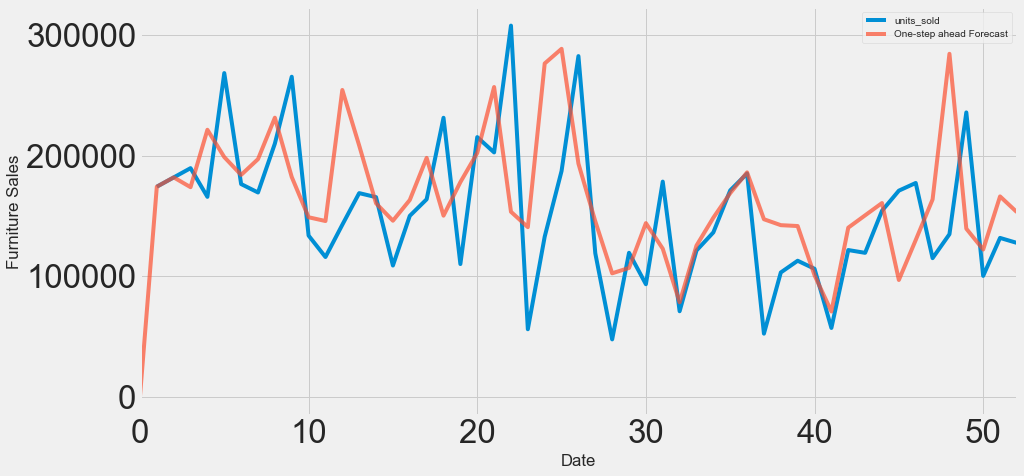

In [502]:
pred = results.get_prediction(start=0, end=52,dynamic=False)
pred_ci = pred.conf_int()
ax = week_of_year.plot(label=label_col)
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [507]:
# Seconds Approach